<a href="https://colab.research.google.com/github/msvt37/Unit-10-A_Yen_For_Future_HW/blob/main/regression_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline

In [2]:
# Mount Google Drive for access to data files
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Regression Analysis: Seasonal Effects with Sklearn Linear Regression
In this notebook, you will build a SKLearn linear regression model to predict Yen futures ("settle") returns with *lagged* Yen futures returns. 

In [3]:
# Futures contract on the Yen-dollar exchange rate:
# This is the continuous chain of the futures contracts that are 1 month to expiration
yen_futures = pd.read_csv(Path("/content/drive/MyDrive/Colab Notebooks/yen.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True)
yen_futures.info()
yen_futures.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10902 entries, 1976-08-02 to 2019-10-15
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Open                        10902 non-null  float64
 1   High                        10902 non-null  float64
 2   Low                         10902 non-null  float64
 3   Last                        10902 non-null  float64
 4   Change                      1415 non-null   float64
 5   Settle                      10902 non-null  float64
 6   Volume                      10902 non-null  float64
 7   Previous Day Open Interest  10902 non-null  float64
dtypes: float64(8)
memory usage: 766.5 KB


,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1976-08-02,3398.0,3401.0,3398.0,3401.0,NaN,3401.0,2.0,1.0
1976-08-03,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-04,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-05,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-06,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0


In [4]:
# Trim the dataset to begin on January 1st, 1990
yen_futures = yen_futures.loc["1990-01-01":, :]
yen_futures.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7515 entries, 1990-01-02 to 2019-10-15
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Open                        7515 non-null   float64
 1   High                        7515 non-null   float64
 2   Low                         7515 non-null   float64
 3   Last                        7515 non-null   float64
 4   Change                      1415 non-null   float64
 5   Settle                      7515 non-null   float64
 6   Volume                      7515 non-null   float64
 7   Previous Day Open Interest  7515 non-null   float64
dtypes: float64(8)
memory usage: 528.4 KB


# Data Preparation

### Returns

In [5]:
# Create a series using "Settle" price percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
yen_futures['Return'] = (yen_futures[["Settle"]].pct_change() * 100)
yen_futures = yen_futures.replace(-np.inf, np.nan)
yen_futures.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7515 entries, 1990-01-02 to 2019-10-15
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Open                        7515 non-null   float64
 1   High                        7515 non-null   float64
 2   Low                         7515 non-null   float64
 3   Last                        7515 non-null   float64
 4   Change                      1415 non-null   float64
 5   Settle                      7515 non-null   float64
 6   Volume                      7515 non-null   float64
 7   Previous Day Open Interest  7515 non-null   float64
 8   Return                      7514 non-null   float64
dtypes: float64(9)
memory usage: 587.1 KB


### Lagged Returns 

In [ ]:
# Create a lagged return using the shift function
yen_futures['Lagged_Return'] = yen_futures.Return.shift()
#Dropping the "Change" column as it only has 1415 values and should not be critical for this model
yen_futures.drop(['Change'], axis= 1, inplace=True)


In [18]:
yen_futures.isnull().sum()

Open                          0
High                          0
Low                           0
Last                          0
Settle                        0
Volume                        0
Previous Day Open Interest    0
Return                        1
Lagged_Return                 2
dtype: int64

In [21]:
yen_futures.dropna(subset=['Return', 'Lagged_Return'], inplace=True)
yen_futures.isnull().sum()

Open                          0
High                          0
Low                           0
Last                          0
Settle                        0
Volume                        0
Previous Day Open Interest    0
Return                        0
Lagged_Return                 0
dtype: int64

### Train Test Split

In [22]:
# Create a train/test split for the data using 2018-2019 for testing and the rest for training
train = yen_futures[:'2017']
test = yen_futures['2018':]

In [23]:
# Create four dataframes:
# X_train (training set using just the independent variables), X_test (test set of of just the independent variables)
# Y_train (training set using just the "y" variable, i.e., "Futures Return"), Y_test (test set of just the "y" variable):
# YOUR CODE HERE!
X_train = train[["Lagged_Return"]]
X_test = test[["Lagged_Return"]]
y_train = train["Return"]
y_test = test["Return"]

In [34]:
X_train

,Lagged_Return
Date,
1990-01-04,0.584197
1990-01-05,1.756933
1990-01-08,-0.827626
1990-01-09,0.129496
1990-01-10,-0.632275
...,...
2017-12-22,0.084621
2017-12-26,0.118370
2017-12-27,0.118230


# Linear Regression Model

In [24]:
# Create a Linear Regression model and fit it to the training data
from sklearn.linear_model import LinearRegression

# Fit a SKLearn linear regression using just the training set (X_train, Y_train):
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

# Make predictions using the Testing Data

Note: We want to evaluate the model using data that it has never seen before, in this case: X_test.

In [32]:
# Make a prediction of "y" values using just the test dataset
predictions = model.predict(X_test)


In [33]:
# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe:
Results = y_test.to_frame()
Results["Predicted Return"] = predictions
Results.head()

,Return,Predicted Return
Date,,
2018-01-02,0.297285,0.003815
2018-01-03,-0.240479,0.003046
2018-01-04,-0.213028,0.008759
2018-01-05,-0.353933,0.008467
2018-01-08,0.062017,0.009964


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ffa621de410>,
      dtype=object)

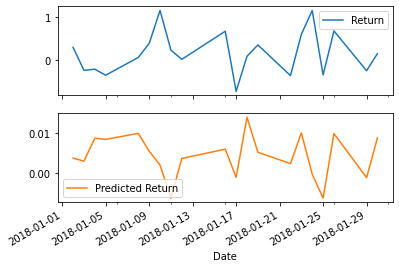

In [28]:
# Plot the first 20 predictions vs the true values
Results[:20].plot(subplots=True)

# Out-of-Sample Performance

Evaluate the model using "out-of-sample" data (X_test and y_test)

In [29]:
from sklearn.metrics import mean_squared_error
# Calculate the mean_squared_error (MSE) on actual versus predicted test "y" 
mse = mean_squared_error(
    Results["Return"],
    Results["Predicted Return"]
)

# Using that mean-squared-error, calculate the root-mean-squared error (RMSE):
rmse = np.sqrt(mse)
print(f"Out-of-Sample Root Mean Squared Error (RMSE): {rmse}")

Out-of-Sample Root Mean Squared Error (RMSE): 0.4136504970669482


# In-Sample Performance

Evaluate the model using in-sample data (X_train and y_train)

In [30]:
# Construct a dataframe using just the "y" training data:
insample = y_train.to_frame()

# Add a column of "in-sample" predictions to that dataframe:  
insample["In-sample Predictions"] = model.predict(X_train)

# Calculate in-sample mean_squared_error (for comparison to out-of-sample)
insample_mse = mean_squared_error(
    insample["Return"],
    insample["In-sample Predictions"]
)

# Calculate in-sample root mean_squared_error (for comparison to out-of-sample)
insample_rmse = np.sqrt(insample_mse)
print(f"In-sample Root Mean Squared Error (RMSE): {insample_rmse}")

In-sample Root Mean Squared Error (RMSE): 0.7059387714146014


# Conclusions

It appears based on the graph of the model predictions and the RMSE values of .413 and .705, that this is a poor model for predicting Yen futures, although out of band performance is better than in-band. The RMSE's indicate the values are not closely clustered around the line of best fit, i.e. the model's predicted values are way off.

During my data analysis, I noticed the "Change" column had quite a few values missing.  I ran the model once with "Change" included, and once without, not seeing a noticeable difference between the two.  I opted for removing it from the final data set to preserve a larger number of rows of the "Settle" and "Returns" values.  


In [38]:
model.score(X_test, y_test)

0.0010352412489498253